In [8]:
import numpy as np
import os
import neat
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=6, suppress=True)

In [2]:
x_0 = np.array([
    [2], 
    [3], 
    [1], 
    [2], 
    [5], 
])

M = np.array([
    [1,1], 
    [1,0], 
    [0,1], 
    [0,1], 
    [0,1], 
])

M_ = np.array([
    [1 , 0, 0, 0], 
    [-1, 0, 0, 0], 
    [-1, 0, 1, 1], 
    [0 , 1,-1,-1], 
    [0 ,-1, 0, 0], 
])


S = np.array([
    [1,0 ], 
    [1,0 ], 
    [1 ,0 ], 
    [0 ,1 ], 
    [0 ,1 ], 
])


D = np.array([
    [0 ,1 ], 
    [1 ,0 ],  
])


m_c = np.array([
    [0.2,], 
    [0.3,],
])

q_c = np.array([
    [-0.3,], 
    [0.1,],
])

a = -np.log(np.array([
    [1], 
    [4], 
    [2], 
    [3], 
    [4], 
]))-1

k = np.array([
    [1], 
    [0.7], 
    [0.1], 
    [0],  
])

v = np.array([
    [0], 
    [0], 
    [0], 
    [0.8],  
])

c = np.array([
    [0.1], 
    [0.1], 
    [0.1], 
    [0.2], 
    [0.1], 
])


x_h = np.array([
    [0], 
    [0], 
    [0], 
    [0], 
    [3], 
])


h = np.array([
    [0], 
    [0], 
    [0], 
    [0], 
    [2], 
])

###

p_0 = np.array([
    [0], 
    [0], 
    [0], 
    [0], 
    [0], 
])

In [3]:
x, p = x_0, p_0
q =  np.dot(  np.diag( np.dot(M, q_c).T[0] ), S )
V = np.dot( q, np.dot(1/(D+1)-1, q.T) )
m = np.dot( M, m_c)

In [4]:
def relu(x) :
    return np.maximum(0,x)

def Energy(x,p) :
    global a, V, m
    
    energy = np.dot(x.T, np.log(x)) + np.dot(a.T, x) + 0.5*np.dot(x.T, np.dot(V, x)) + 0.5*(np.dot( (1/m.T), (p*p*x)))
    
    return energy[0]

def Flow(x,p) :
    global M_, k, v, h, x_h, c
    
    grad_x = (np.log(x)+1).T + a.T + np.dot(x.T, V) + (0.5*(1/m)*p*p).T
    grad_p = ((1/m)*p*x).T
    
    chemical_flow_x = -np.dot(M_, (k.T*(np.exp( np.dot(grad_x, M_)) -1 )*(np.exp(-0.5*np.dot(grad_x, M_) + 0.5*np.dot(np.log(x.T), np.abs(M_)))) ).T)
    hamiltonian_flow_x = np.dot(M_, v*(np.dot(grad_p, M_).T) )
    hamiltonian_flow_p = -np.dot(M_, v*(np.dot(grad_x, M_).T) )
    colision_flow_p = -c*(grad_p).T
    external_homeostasis_flow_x = h*(x_h-x)
    
    #return chemical_flow_x ,   colision_flow_p
    return chemical_flow_x + hamiltonian_flow_x,  hamiltonian_flow_p + colision_flow_p
    #return chemical_flow_x + hamiltonian_flow_x + external_homeostasis_flow_x,  hamiltonian_flow_p + colision_flow_p

In [5]:
(1/m).T

array([[2.      , 5.      , 3.333333, 3.333333, 3.333333]])

In [6]:
x

array([[2],
       [3],
       [1],
       [2],
       [5]])

In [7]:
flow_x, flow_p = Flow(x,p) 
flow_x, flow_p

(array([[-4.596194],
        [ 4.596194],
        [ 4.650644],
        [ 1.360058],
        [-1.414508]]),
 array([[-0.      ],
        [-0.      ],
        [ 0.306146],
        [-0.306146],
        [-0.      ]]))

In [8]:
energy = Energy(x,p)

In [9]:
np.dot(M.T, flow_x)

array([[0.],
       [0.]])

[2 3 1 2 5 0 0 0 0 0]
(50, 10)


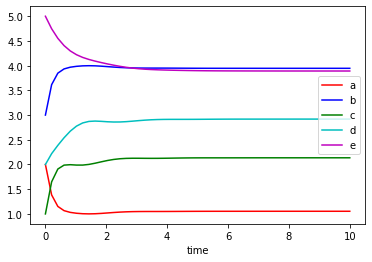

[2. 3. 1. 2. 5.]
[1.053578 3.946422 2.135768 2.918823 3.891831]


In [10]:

def model(xp,t) :
    global M_,a, k, v, h, x_h, c
    
    xp_2d = xp.reshape(2,-1)
    x_m = np.array([xp_2d[0]]).T
    p_m = np.array([xp_2d[1]]).T
    
    ###
    
    grad_x = (np.log(x_m)+1).T + a.T + np.dot(x_m.T, V) + (0.5*(1/m)*p_m*p_m).T
    grad_p = ((1/m)*p_m*x_m).T
    
    chemical_flow_x = -np.dot(M_, (k.T*(np.exp( np.dot(grad_x, M_)) -1 )*(np.exp(-0.5*np.dot(grad_x, M_) + 0.5*np.dot(np.log(x_m.T), np.abs(M_)))) ).T)
    hamiltonian_flow_x = np.dot(M_, v*(np.dot(grad_p, M_).T) )
    hamiltonian_flow_p = -np.dot(M_, v*(np.dot(grad_x, M_).T) )
    colision_flow_p = -c*(grad_p).T
    external_homeostasis_flow_x = h*(x_h-x_m)
    
    
    ###
    flow_x, flow_p = chemical_flow_x + hamiltonian_flow_x,  hamiltonian_flow_p + colision_flow_p
    ##flow_x, flow_p =hamiltonian_flow_x,  hamiltonian_flow_p + colision_flow_p
    ##flow_x, flow_p =hamiltonian_flow_x,  hamiltonian_flow_p
    dxpdt = np.array([flow_x, flow_p]).reshape(-1)
    return dxpdt

xp0 = np.array([x, p]).reshape(-1)
print(xp0)
t = np.linspace(0,10)
xp = odeint(model, xp0, t)
print(xp.shape)
plt.plot(t, xp[:,0], 'r-', label='a')
plt.plot(t, xp[:,1], 'b-', label='b')
plt.plot(t, xp[:,2], 'g-', label='c')
plt.plot(t, xp[:,3], 'c-', label='d')
plt.plot(t, xp[:,4], 'm-', label='e')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()


print(xp[0,:5])
print(xp[-1,:5])

In [11]:
energy = []
for i in range(len(xp)) :
    energy.append(Energy(np.array([xp[i].reshape(2,-1)[0]]).T,  np.array([xp[i].reshape(2,-1)[1]]).T))

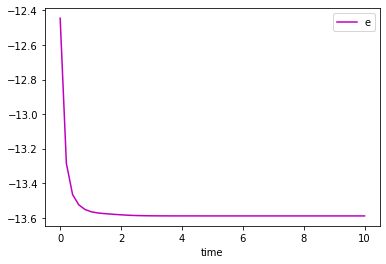

In [12]:
plt.plot(t, energy, 'm-', label='e')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()

Executing eagerly:  True

 ****** Running generation 0 ****** 

react_rules : {}
G set : [[1, 0, 0], [0, 1, 0]]
A set : {'1/0/0': 1.430675267460494e-07, '0/1/0': 6.617463329189464e-05}
S set: [[0, 1], [1, 0], [1, 1]]
D mat: [[0, inf, inf], [inf, 0, 0.13915468109926363], [inf, 0.13915468109926363, 0]]
("node list : {'1/0/0-1/0': [9.999996018661623, [1, 0], [1, 0], "
 '1.4262189229468263e-07, 8.374871264118681, 0.999991977739284, [1, 0, 0]], '
 "'1/0/0-1/1': [9.98344074791462, [1, 0], [1, 1], 1.4250341844009036e-07, "
 "8.398707472921284, 0.9999897391931775, [1, 0, 0]], '0/1/0-0/1': "
 '[8.939261172797227, [0, 1], [0, 1], 6.45457617634448e-05, 8.33851484575441, '
 "0.9999925411050632, [0, 1, 0]], '0/1/0-1/0': [9.99995575028526, [0, 1], [1, "
 '0], 6.596850897373419e-05, 8.68588671227964, 0.9999999867488454, [0, 1, 0]], '
 "'0/1/0-1/1': [8.874155598719778, [0, 1], [1, 1], 6.59137099284118e-05, "
 '8.705482549355608, 0.999999991606522, [0, 1, 0]]}')
x_0


,0
1/0/0-1/0,9.999996
1/0/0-1/1,9.983441
0/1/0-0/1,8.939261
0/1/0-1/0,9.999956
0/1/0-1/1,8.874156


p_0


,0
1/0/0-1/0,0
1/0/0-1/1,0
0/1/0-0/1,0
0/1/0-1/0,0
0/1/0-1/1,0


M


,0,1
1/0/0-1/0,1,0
1/0/0-1/1,1,0
0/1/0-0/1,0,1
0/1/0-1/0,0,1
0/1/0-1/1,0,1


M_


,0/1/0-1/1-1/0,0/1/0-1/0-1/1
1/0/0-1/0,0,0
1/0/0-1/1,0,0
0/1/0-0/1,0,0
0/1/0-1/0,1,-1
0/1/0-1/1,-1,1


S


,0/1,1/0,1/1
1/0/0-1/0,0,1,0
1/0/0-1/1,0,0,1
0/1/0-0/1,1,0,0
0/1/0-1/0,0,1,0
0/1/0-1/1,0,0,1


D


,0/1,1/0,1/1
0/1,0.0,inf,inf
1/0,inf,0.000000,0.139155
1/1,inf,0.139155,0.000000


a


,0
1/0/0-1/0,1.426219e-07
1/0/0-1/1,1.425034e-07
0/1/0-0/1,6.454576e-05
0/1/0-1/0,6.596851e-05
0/1/0-1/1,6.591371e-05


k


,0
0/1/0-1/1-1/0,0
0/1/0-1/0-1/1,0


v


,0
0/1/0-1/1-1/0,0.999477
0/1/0-1/0-1/1,0.999900


c


,0
1/0/0-1/0,1
1/0/0-1/1,1
0/1/0-0/1,1
0/1/0-1/0,1
0/1/0-1/1,1


x_h


,0
1/0/0-1/0,8.374871
1/0/0-1/1,8.398707
0/1/0-0/1,8.338515
0/1/0-1/0,8.685887
0/1/0-1/1,8.705483


h


,0
1/0/0-1/0,0.999992
1/0/0-1/1,0.999990
0/1/0-0/1,0.999993
0/1/0-1/0,1.000000
0/1/0-1/1,1.000000


m_c


,0
0,0.895660
1,0.303293


q_c


,0
0,-0.971779
1,0.999767


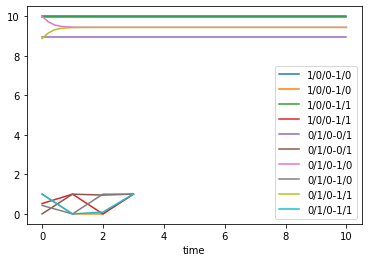

[9.99999602 9.98344075 8.93926117 9.99995575 8.8741556 ]
[9.99999602 9.98344075 8.93926117 9.4413631  9.43274825]


SystemExit: 

C:\Users\arizona95\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
import os
import numpy as np
import gym
import neat
import tensorflow as tf
from tf_neat.multi_env_eval import MultiEnvEvaluator
from tf_neat.neat_reporter import LogReporter
from tf_neat.recurrent_net import RecurrentNet
import visualize
import pandas as pd
from IPython.display import display, HTML

# Activate eager TensorFlow execution
tf.executing_eagerly()
print("Executing eagerly: ", tf.executing_eagerly())

max_env_steps = 200

c_v=2
s_v=2

test = ""
test1 = ""

def make_env():
    return gym.make("CartPole-v0")


def make_net(genome, config, bs):
    return RecurrentNet.create(genome, config, bs)


def activate_net(net, states):
    global test
    test =states
    outputs = net.activate(states).numpy()
    
    return  (outputs[:, 0] > 0.5 ).astype(int) 


def run(n_generations):
    # Load the config file, which is assumed to live in
    # the same directory as this script.
    config_path = os.path.join(os.path.dirname(os.path.abspath('')), "paper/tf_neat/neat.cfg")
    config = neat.Config(
        neat.DefaultGenome,
        neat.DefaultReproduction,
        neat.DefaultSpeciesSet,
        neat.DefaultStagnation,
        config_path,
    )

    evaluator = MultiEnvEvaluator(
        make_net, activate_net, make_env=make_env, max_env_steps=max_env_steps
    )

    def eval_genomes(genomes, config):
        global test1
        test1 = genomes
        for _, genome in genomes:
            genome.fitness = evaluator.eval_genome(genome, config)

    pop = neat.Population(config)
    stats = neat.StatisticsReporter()
    pop.add_reporter(stats)
    reporter = neat.StdOutReporter(True)
    pop.add_reporter(reporter)
    logger = LogReporter("./logs/neat.json", evaluator.eval_genome)
    pop.add_reporter(logger)

    pop.run(eval_genomes, n_generations)


run(1)

In [17]:
import pandas as pd
c =[[0, 0], [0, 1]]
sn = list(map(lambda x:"/".join(str(e) for e in x),c))
k =pd.DataFrame.from_dict(c)
k.columns = sn
k = k.T
k.columns = sn

In [24]:
from collections import OrderedDict
a = dict()
a["t1"]=3
a["t2"]=2
if "t3" in a :
    print("true")

In [18]:
k

,0/0,0/1
0/0,0,0
0/1,0,1


In [14]:
dict_a = {"a":{"s1":1, "s2":2}, "b":{"s3":3}}
a = pd.DataFrame.from_dict(dict_a).T

In [15]:
a

,s1,s2,s3
a,1.0,2.0,NaN
b,NaN,NaN,3.0


In [4]:
a = np.array([np.inf])

In [6]:
1/a

array([0.])

In [8]:
np.array(a)

array([[1, 2]], dtype=int64)

In [14]:
list_b = [[1,2],[3,4]]
b = pd.DataFrame.from_dict(list_b).T

In [15]:
b

,0,1
0,1,3
1,2,4


In [10]:
import itertools
lst = list(map(lambda x:list(x),list(itertools.product([0, 1], repeat=2))))

In [11]:
lst

[[0, 0], [0, 1], [1, 0], [1, 1]]

In [ ]:
for k in network_size :
    print(v)

In [ ]:
list(np.array([1,2])+np.array([3,4]))

In [ ]:
int(4.5)

In [ ]:
print(np.array([1, 0, 0, 1, 0, 0], dtype=np.float32))

In [ ]:
print(tf.convert_to_tensor([1, 0, 0, 1, 0, 0], dtype=tf.float32))

In [ ]:
test

In [ ]:
a = [1, 0, 0, 1, 0, 0]

[np.array(a)]

In [ ]:
test

In [ ]:
config_path = os.path.join(os.path.dirname(os.path.abspath('')), "paper/tf_neat/neat.cfg")
config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)

In [ ]:
config.genome_config.input_keys

In [8]:
dir(test1)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [7]:
test1

<function tuple.count(value, /)>

In [21]:

config_path = os.path.join(os.path.dirname(os.path.abspath('')), "paper/tf_neat/neat.cfg")
config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)
for _, genome in [test1[2]]:
    node_names = {-1:'A', -2: 'B', -3: 'C', -4: 'D', 0:'output'}
    stats = neat.StatisticsReporter()
    visualize.draw_net(config, genome, True, node_names=node_names)
    print(genome)

Key: 114
Fitness: 9.0
Nodes:
	0 DefaultNodeGene(key=0, bias=1.7983796236213394, response=1.0, activation=sigmoid, aggregation=sum)
	114 DefaultNodeGene(key=114, bias=0.7633495953500787, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-3, 114), weight=0.3831917445632024, enabled=True)
	DefaultConnectionGene(key=(-2, 114), weight=0.039226573892899796, enabled=True)
	DefaultConnectionGene(key=(-1, 114), weight=0.6578286707005735, enabled=True)
	DefaultConnectionGene(key=(114, 0), weight=-0.35823329415372324, enabled=True)


In [14]:
a = [1,2,3]

print(''.join(str(e) for e in a))


123


In [12]:
a[0]

1

In [15]:
max(-2,0)

0

In [4]:
D = [[0]*3]*3

In [14]:
D = [[0 for x in range(3)] for y in range(3)] 

In [15]:
D

[[0, 0, 0], [0, 0, 0], [0, 0, 0]]

In [16]:
D[0][0]=1

In [17]:
D

[[1, 0, 0], [0, 0, 0], [0, 0, 0]]